<a href="https://colab.research.google.com/github/michalis0/DataScience_and_MachineLearning/blob/master/13-interpretability-for-ai/Week_13_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install datasets
import datasets
import pandas as pd
import seaborn as sns
import transformers
!pip install shap
import shap
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
!pip install lime
import lime
!pip install interpret
import interpret
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt


# Explainable AI

Explailable AI (XAI) aims to enhance transparency by clarifying the reasoning behind the predictions of (complex) AI models, which is crucial for their practical use and widespread adoption, particularly in high-stakes applications (healthcare, legal). Below we show examples of such approaches.

<img src='https://assets.spe.org/dims4/default/f6b3d58/2147483647/strip/true/crop/696x392+0+0/resize/800x451!/quality/90/?url=http%3A%2F%2Fspe-brightspot.s3.us-east-2.amazonaws.com%2Fae%2F27%2F97e3d6195614a45bed36e7a965e2%2Fblackbox.jpg' width="500">

### Examples of XAI models
Various XAI approaches exist. In the following we look at two very popular ones, namely, `shap`and `lime`.


## SHAP (SHapley Additive exPlanations)

**SHAP** is a popular library used for interpreting the output of machine learning models. It is based on the concept of Shapley values from cooperative game theory, which allocate the contribution of each feature to the model's predictions.

### How SHAP Works:
1. **Feature Contribution**: For each prediction, SHAP computes the contribution of each feature to the prediction by considering all possible feature combinations.
2. **Additive Feature Attribution**: The sum of SHAP values for all features equals the model’s prediction, ensuring consistency.

### Example of a sentiment analisys model
Let's start with an example of `shap` over a `Sentiment Analisys` model.

For this example we will use a pretrained bert model, and we will try to identify how each feature affects the final prediction.

In [2]:
%%capture
# load the dataset
dataset = datasets.load_dataset("emotion", split="train")
data = pd.DataFrame({"text": dataset["text"], "emotion": dataset["label"]})

In [3]:
%%capture
# load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    "nateraw/bert-base-uncased-emotion", use_fast=True
)

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "nateraw/bert-base-uncased-emotion"
).cuda() # if this step fails, relaunch your google colab with a T4 runtime, ensuring cuda support

# build a pipeline object to do predictions
pred = transformers.pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    top_k=None,
)

In [4]:
# build an explainer function that extends our predictions pipeline
shap_explainer = shap.Explainer(pred)

In [6]:
# show the explainer
shap_values = shap_explainer(["I am happy to have followed the XAI lecture, and it is sad it is already over"])
shap.plots.text(shap_values)

  0%|          | 0/420 [00:00<?, ?it/s]

### Your turn!

Plot a `shap` barplot that represents the weights of each word in a sentence for different emotions. You can use the documentation available [here](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Emotion%20classification%20multiclass%20example.html).

In [7]:
shap.plots.text(shap_values[:, :, "anger"])
shap.plots.text(shap_values[:, :, "joy"])
shap.plots.text(shap_values[:, :, "love"])
shap.plots.text(shap_values[:, :, "fear"])
shap.plots.text(shap_values[:, :, "surprise"])
shap.plots.text(shap_values[:, :, "sadness"])






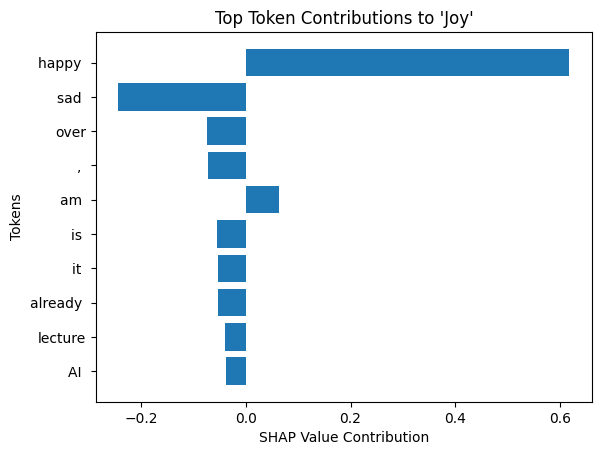

In [8]:
# Extract SHAP values for the 'joy' class
joy_index = 1  # Index of 'joy' in the model's output
joy_shap_values = shap_values.values[0, :, joy_index]  # (21 tokens)

# Map tokens to their contributions
tokens = shap_values.data[0]  # Tokenized text
token_contributions = dict(zip(tokens, joy_shap_values))

# Visualize as a bar plot
import matplotlib.pyplot as plt

# Sort tokens by absolute contribution
sorted_contributions = sorted(token_contributions.items(), key=lambda x: abs(x[1]), reverse=True)

# Prepare data for plotting
sorted_tokens, sorted_values = zip(*sorted_contributions[:10])  # Top 10 tokens

# Plot
plt.barh(sorted_tokens, sorted_values)
plt.xlabel("SHAP Value Contribution")
plt.ylabel("Tokens")
plt.title("Top Token Contributions to 'Joy'")
plt.gca().invert_yaxis()
plt.show()


## LIME
We will now create a similar model using `lime` explainability over youtube spam classifications. To do so we will train a model on the labeled comments of the videos from PSY, Shakira, LMFAO and Katy Perry, and then predict if some comments are spam or not.



### Classification
We will try to identify bellow the importance of each factor in the computers decision making.

We will apply it on two models, a `Random Forest Classifier` and a `Decision Tree`

In [23]:
psy = pd.read_csv('https://raw.githubusercontent.com/JasminaZHAW/XAI/refs/heads/main/data/Youtube01-Psy.csv')
perry = pd.read_csv('https://raw.githubusercontent.com/JasminaZHAW/XAI/refs/heads/main/data/Youtube02-KatyPerry.csv')
LMFAO = pd.read_csv('https://raw.githubusercontent.com/JasminaZHAW/XAI/refs/heads/main/data/Youtube03-LMFAO.csv')
Eminem = pd.read_csv('https://raw.githubusercontent.com/JasminaZHAW/XAI/refs/heads/main/data/Youtube04-Eminem.csv')
Shakira = pd.read_csv('https://raw.githubusercontent.com/JasminaZHAW/XAI/refs/heads/main/data/Youtube05-Shakira.csv')
full_train = pd.concat([psy, perry, LMFAO, Shakira, Eminem]).reset_index().drop(columns = ['index'])

In [24]:
display(full_train.head(3))

COMMENT_ID            AUTHOR  \
0  LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU         Julius NM   
1  LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A       adam riyati   
2  LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8  Evgeny Murashkin   

                  DATE                                            CONTENT  \
0  2013-11-07T06:20:48  Huh, anyway check out this you[tube] channel: ...   
1  2013-11-07T12:37:15  Hey guys check out my new channel and our firs...   
2  2013-11-08T17:34:21             just for test I have to say murdev.com   

   CLASS  
0      1  
1      1  
2      1

In [25]:
# Load useful libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

X= full_train['CONTENT']
y= full_train['CLASS']


# Using default tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words="english")

# Learn the vocabulary dictionary and return document-term matrix
features = tfidf.fit_transform(X)

# Visualize result in dataframe
X = pd.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names_out(),
)


# Create Train & Test Data
X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y,test_size=0.3,
                                                	stratify =y,
                                                	random_state = 13)

# Build the model
rf_clf = RandomForestClassifier(max_features=2, n_estimators =100 ,bootstrap = True)

rf_clf.fit(X_train, y_train)
predict_fn_clf = lambda x: rf_clf.predict_proba(x).astype(float)

# Make prediction on the testing data
y_pred = rf_clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       308
           1       0.91      0.99      0.95       279

    accuracy                           0.95       587
   macro avg       0.95      0.95      0.95       587
weighted avg       0.95      0.95      0.95       587



In [26]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

# Get the class names
class_names = ['Not spam', 'Spam']

# Get the feature names
feature_names = list(X_train.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
lime_explainer = LimeTabularExplainer(X_train.values, feature_names =
                                 feature_names,
                                 class_names = class_names,
                                 mode = 'classification')



In [27]:
# Explain the prediction for a target sample
choosen_instance = X_test.loc[:].values[0]
exp = lime_explainer.explain_instance(choosen_instance, predict_fn_clf,num_features=10)
exp.show_in_notebook(show_all=False)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


# Inherently Interpretable Models

An individual’s annual income results from various factors. Intuitively, it is influenced by the individual’s education level, age, gender, occupation, and etc. Here we focus on the task of predicting whether annual income of an individual exceeds $50K/yr based on census data (known as "Census Income" dataset). You can find description of all the input features of the dataset [here](https://archive.ics.uci.edu/dataset/2/adult)

In [9]:
# Load the data
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None)

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label]

# Create Train & Test Data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify =y, random_state = 13)

Fit an explainable boosting machine model (EBM) to address the task. EBM is an interpretable model developed at Microsoft Research. You can find more details on it [here](https://www.cs.cornell.edu/~yinlou/papers/lou-kdd13.pdf). It uses modern machine learning techniques like bagging, gradient boosting, and automatic interaction detection to breathe new life into traditional GAMs (Generalized Additive Models). This makes EBMs as accurate as state-of-the-art techniques like random forests and gradient boosted trees.

In [28]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import roc_auc_score

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

# You can also try other inherently interpretable classifiers from the interpret library like:
# LogisticRegression, DecisionTreeClassifier, RuleListClassifier, ...

# Compute AUC performance on test set
auc = roc_auc_score(y_test, ebm.predict_proba(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

AUC: 0.925


In [25]:
# Global understanding of the model
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

In [27]:
# Understand individual predictions for the first 10 samples in the test set
ebm_local = ebm.explain_local(X_test[:10], y_test[:10], 0)
show(ebm_local)
